In [2]:
require(data.table)
require(dplyr)
require(tidyverse)
require(phyloseq)
require(DESeq2)
require(genefilter)
require(ggplot2)
require(vegan)
require(RColorBrewer)
require(metacoder)
options(repr.plot.width=20, repr.plot.height=15)

In [13]:
ps_trim <-readRDS(file = "/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/RDS/ps_trim.rds")
ps_trim

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 15184 taxa and 22 samples ]
sample_data() Sample Data:       [ 22 samples by 15198 sample variables ]
tax_table()   Taxonomy Table:    [ 15184 taxa by 6 taxonomic ranks ]

In [14]:
ps_N <-readRDS(file = "/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/RDS/ps.rds")
ps_N

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 95300 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95314 sample variables ]
tax_table()   Taxonomy Table:    [ 95300 taxa by 6 taxonomic ranks ]

In [50]:
ps<-readRDS(file = "/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/RDS/ps_final.rds")
#removing any taxa that don't show up in any samples to speed up the process
ps
ps <- prune_taxa(taxa_sums(ps) > 0, ps)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 95266 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95280 sample variables ]
tax_table()   Taxonomy Table:    [ 95266 taxa by 6 taxonomic ranks ]

In [51]:
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 93542 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95280 sample variables ]
tax_table()   Taxonomy Table:    [ 93542 taxa by 6 taxonomic ranks ]

In [54]:
#getting rid of samples in phyloseq with very low-abundance or rarely occurring taxa
    # Remove taxa not seen in at least 3 samples AND total abundance less than 6
    littlefilter_ps <- phyloseq::filter_taxa(ps, function(x) sum(x > 0) > 2 & sum(x) > 2, TRUE)

In [55]:
littlefilter_ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11659 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95280 sample variables ]
tax_table()   Taxonomy Table:    [ 11659 taxa by 6 taxonomic ranks ]

In [56]:
    # Remove taxa not seen in at least 3 samples AND total abundance less than 6
    bigfilter_ps <- phyloseq::filter_taxa(ps, function(x) sum(x > 0) > 5 & sum(x) > 9, TRUE)
bigfilter_ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3299 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95280 sample variables ]
tax_table()   Taxonomy Table:    [ 3299 taxa by 6 taxonomic ranks ]

In [57]:
    # Remove taxa not seen in at least 3 samples AND total abundance less than 6
    medfilter_ps <- phyloseq::filter_taxa(ps, function(x) sum(x > 0) > 2 & sum(x) > 5, TRUE)
medfilter_ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11659 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95280 sample variables ]
tax_table()   Taxonomy Table:    [ 11659 taxa by 6 taxonomic ranks ]

In [58]:
  # Remove taxa not seen in at least 3 samples AND total abundance less than 6
    filter4_ps <- phyloseq::filter_taxa(ps, function(x) sum(x > 0) > 5 & sum(x) > 2, TRUE)
filter4_ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3299 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95280 sample variables ]
tax_table()   Taxonomy Table:    [ 3299 taxa by 6 taxonomic ranks ]

In [60]:
ps <- phyloseq::filter_taxa(ps, function(x) sum(x > 0) > 1 & sum(x) > 2, TRUE)
ps                               

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 22765 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95280 sample variables ]
tax_table()   Taxonomy Table:    [ 22765 taxa by 6 taxonomic ranks ]

### renaming ASV for shorter names (ease of labeling) but making a map to get back to original sequences

In [61]:
#renaming the taxa to a short string while maintaining full dna seq in the background
dna <- Biostrings::DNAStringSet(taxa_names(ps))
names(dna) <- taxa_names(ps)
ps <- merge_phyloseq(ps, dna)
taxa_names(ps) <- paste0("ASV", seq(ntaxa(ps)))
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 22765 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95280 sample variables ]
tax_table()   Taxonomy Table:    [ 22765 taxa by 6 taxonomic ranks ]
refseq()      DNAStringSet:      [ 22765 reference sequences ]

In [62]:
# map data.frame from ASV labels to DNA sequences
asv_map <- data.frame(
  ASV = paste0("ASV", seq_along(dna)),
  Sequence = as.character(dna),
  stringsAsFactors = FALSE)

In [63]:
saveRDS(asv_map, file = "/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/RDS/asv_map.rds")

DESeq doesnt like normalized
- do not include this:
- ps_norm = transform_sample_counts(ps, function(x) 1E6 * x / sum(x))

### filtering out cholorplast and mitochondria

In [64]:
#isolate just bacteria
ps_bac=subset_taxa(ps, Kingdom=="Bacteria")
ps_bac

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 21980 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95280 sample variables ]
tax_table()   Taxonomy Table:    [ 21980 taxa by 6 taxonomic ranks ]
refseq()      DNAStringSet:      [ 21980 reference sequences ]

In [65]:
#remove chloroplast order
ps_nochlo=subset_taxa(ps_bac, Order!="Chloroplast")
ps_nochlo

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 17114 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95280 sample variables ]
tax_table()   Taxonomy Table:    [ 17114 taxa by 6 taxonomic ranks ]
refseq()      DNAStringSet:      [ 17114 reference sequences ]

In [66]:
ps_clean=subset_taxa(ps_nochlo, Family!="Mitochondria")

In [67]:
theme_set(theme_bw())

### ps objects to otu table and sample metadata

In [68]:
# convert the sample_data() within a phyloseq object to a vegan compatible data object
pssd2veg <- function(ps_clean) {
  sd_nochlo <- sample_data(ps_clean)
  return(as(sd_nochlo,"data.frame"))
}

#using phyloseq nmds plot no chloroplast
sample_clean <- pssd2veg(ps_clean)

In [69]:
# convert the otu_table() within a phyloseq object to a vegan compatible data object
psotu2veg <- function(ps_clean) {
  otu_clean <- otu_table(ps_clean)
  if (taxa_are_rows(otu_clean)) {
    otu_clean <- t(otu_clean)
  }
  return(as(otu_clean, "matrix"))
}

# Extract normalized OTU matrix and sample data
otu_clean <- psotu2veg(ps_clean)


In [70]:
# transposing otu for deseq compatibility 
otu <- t(otu_clean)

In [71]:
class(otu)

[1] "matrix" "array"

### Subgrouping to get parent groups for DEseq2

In [72]:
set.seed(12)

In [73]:
#making plots small 
options(repr.plot.width = 15, repr.plot.height = 10)
#dissimilarity
dij <- vegdist(otu_clean) ## bray curtis dissimilarity
clu <- hclust(dij, method = "average")
# 2 clusters bc I know Date_16S is already driving into 2 clusters
grp <- cutree(clu, 2)

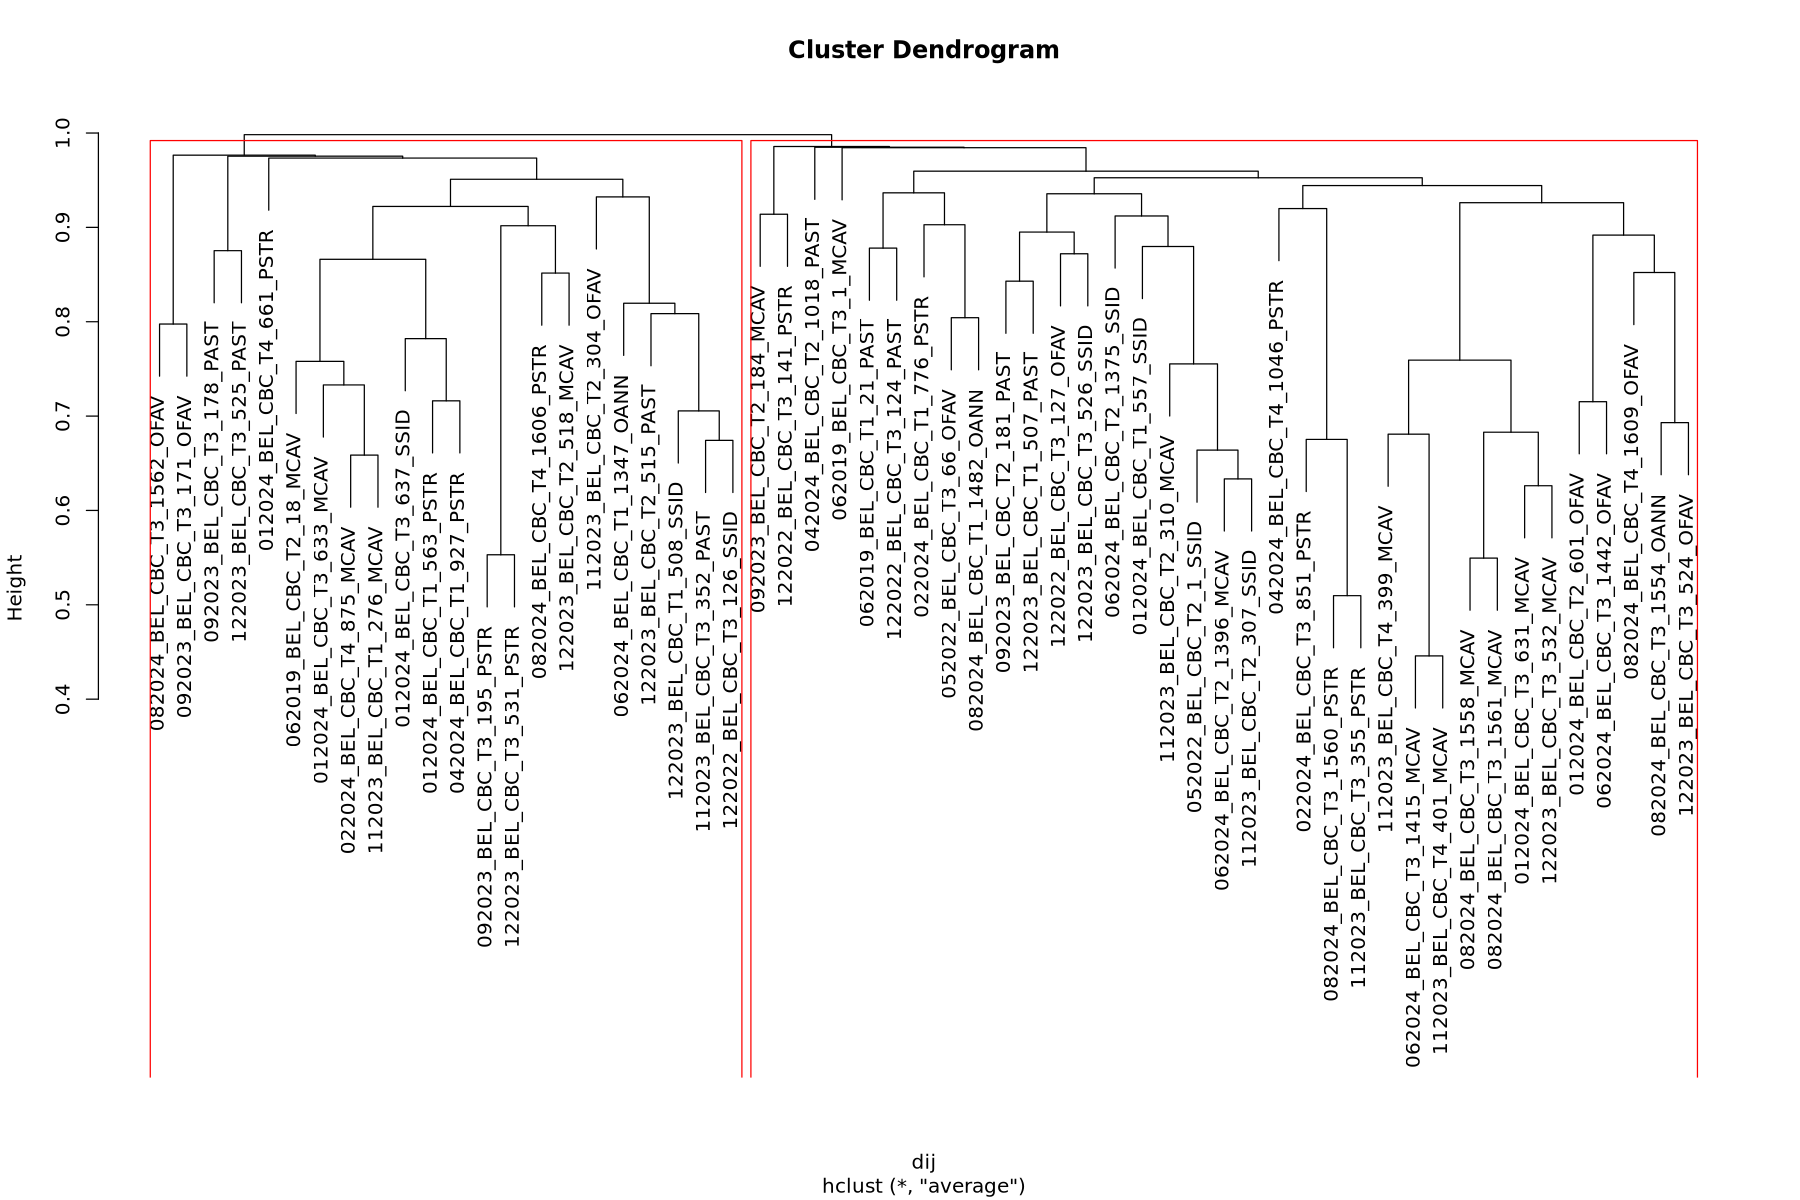

In [74]:
# visualizing the parent dendogram
plot(clu); rect.hclust(clu, k=2, border="red")

In [75]:
# Subset your original data
# Get indices of samples in each parent cluster
grp1_ids <- names(grp[grp == 1])
grp2_ids <- names(grp[grp == 2])
head(grp1_ids)
class(grp1_ids)

[1] "012024_BEL_CBC_T1_557_SSID"  "012024_BEL_CBC_T2_601_OFAV" 
[3] "012024_BEL_CBC_T3_631_MCAV"  "022024_BEL_CBC_T1_776_PSTR" 
[5] "022024_BEL_CBC_T3_851_PSTR"  "042024_BEL_CBC_T2_1018_PAST"

[1] "character"

In [76]:
# Convert to data frame for safe merging
#remember grp is what I named the parent clusters when I split them for the red dendogram
parent <- data.frame(
  Cluster = factor(grp)
)
head(parent)

,Cluster
,<fct>
012024_BEL_CBC_T1_557_SSID,1
012024_BEL_CBC_T1_563_PSTR,2
012024_BEL_CBC_T2_601_OFAV,1
012024_BEL_CBC_T3_631_MCAV,1
012024_BEL_CBC_T3_633_MCAV,2
012024_BEL_CBC_T3_637_SSID,2


In [77]:
length(rownames(sample_clean))
length(rownames(parent))

[1] 57

[1] 57

In [78]:
# Check that all rownames in sample_clean are in parent
stopifnot(all(rownames(sample_clean) %in% rownames(parent)))
# Subset parent and keep it a data frame
parent_subset <- parent[rownames(sample_clean), , drop = FALSE]
# Combine using cbind
sample_clean$Cluster <- parent_subset$Cluster

In [79]:
table(sample_clean$Cluster) #35 and 22
any(is.na(sample_clean$Cluster))


 1  2 
35 22 

[1] FALSE

### DESeq2 set up

In [80]:
package.version("DESeq2")

[1] "1.38.3"

In [81]:
# Step 1: Add the cleaned sample data (with cluster assignments) back to the phyloseq object
sample_data(ps_clean) <- sample_data(sample_clean)
head(sample_data(ps_clean))

,Health_Status,colony,Date_16S,double_band,date_sampled,transect,species,MonthYear,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA,⋯,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGCCGTGGTGTGTTTGGAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTTAATGATACGGCGACCACCGAGATCTACACAATTCCGGTCGTCGGCAGCGTCAGATGTGTATAAGAGACAGGT,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACGCATGTCTATCTGGTGTGGCGGGGTTTGTTTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGGCGGGGTGTGGTTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,input,filtered,denoisedF,denoisedR,merged,nonchim,Cluster
,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<fct>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>
012024_BEL_CBC_T1_557_SSID,Healthy,1_3,3_4_2025,y,012024,T1,SSID,Jan 2024,580,0,⋯,0,0,0,189569,176082,171436,173162,142705,129120,1
012024_BEL_CBC_T1_563_PSTR,Healthy,1_12,3_6_2025,,012024,T1,PSTR,Jan 2024,0,0,⋯,0,0,0,98511,89332,88739,88868,87695,44586,2
012024_BEL_CBC_T2_601_OFAV,Healthy,2_79,3_4_2025,,012024,T2,OFAV,Jan 2024,279,6,⋯,0,0,0,280306,263766,262084,262620,250901,173382,1
012024_BEL_CBC_T3_631_MCAV,Healthy,3_21,3_4_2025,,012024,T3,MCAV,Jan 2024,328,0,⋯,0,0,0,536786,497419,495884,496191,481026,404922,1
012024_BEL_CBC_T3_633_MCAV,Healthy,3_2,3_6_2025,,012024,T3,MCAV,Jan 2024,0,0,⋯,0,0,0,163169,154836,154032,153929,151918,62656,2
012024_BEL_CBC_T3_637_SSID,Healthy,3_5,3_6_2025,,012024,T3,SSID,Jan 2024,0,128,⋯,0,0,0,22750,21151,20332,20453,19464,17819,2


In [82]:
# Step 2: Ensure the order of samples in OTU matches the phyloseq object
otu <- otu[, sample_names(ps_clean)]

# Step 3: Replace the OTU table in the phyloseq object
otu_table(ps_clean) <- otu_table(otu, taxa_are_rows = TRUE)
head(otu_table(ps_clean))

,012024_BEL_CBC_T1_557_SSID,012024_BEL_CBC_T1_563_PSTR,012024_BEL_CBC_T2_601_OFAV,012024_BEL_CBC_T3_631_MCAV,012024_BEL_CBC_T3_633_MCAV,012024_BEL_CBC_T3_637_SSID,012024_BEL_CBC_T4_661_PSTR,022024_BEL_CBC_T1_776_PSTR,022024_BEL_CBC_T3_851_PSTR,022024_BEL_CBC_T4_875_MCAV,⋯,122022_BEL_CBC_T3_141_PSTR,122023_BEL_CBC_T1_507_PAST,122023_BEL_CBC_T1_508_SSID,122023_BEL_CBC_T2_515_PAST,122023_BEL_CBC_T2_518_MCAV,122023_BEL_CBC_T3_524_OFAV,122023_BEL_CBC_T3_525_PAST,122023_BEL_CBC_T3_526_SSID,122023_BEL_CBC_T3_531_PSTR,122023_BEL_CBC_T3_532_MCAV
ASV1,580,0,279,328,0,0,0,30,193,0,⋯,0,104,0,0,0,3669,0,68,0,39
ASV3,4781,0,2321,117,0,0,162,22,845,0,⋯,0,8990,0,0,0,1641,0,235,0,69
ASV5,60,0,119,0,0,0,76,0,318,0,⋯,0,4589,0,0,0,596,0,90,0,27
ASV8,32,0,0,0,17,0,97,0,0,0,⋯,0,0,0,27,85,0,218,0,0,0
ASV9,367,0,543,121,0,0,0,0,0,0,⋯,0,103,0,0,0,894,0,52,0,39
ASV10,0,34,0,0,0,0,0,0,364,64,⋯,0,0,0,0,0,0,0,114,83,46


In [83]:
cluster_dds = phyloseq_to_deseq2(ps_clean, ~ Cluster)
gm_mean = function(row) if (all(row == 0)) 0 else exp(mean(log(row[row != 0])))
geoMeans = apply(otu, 1, gm_mean)
cluster_dds <- estimateSizeFactors(cluster_dds, geoMeans=geoMeans, locfunc=shorth)
cluster_dds = DESeq(cluster_dds, test="Wald", fitType="parametric")

converting counts to integer mode

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 7549 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



DESeq2 is trying to fit the otus into a a regression (GLM) 
y = Bo + B1X1 ...
y= outcome of gene expression
Bo= baseline
x= value of cluster (1 or 2)
in my case there is only one factor (cluster) with two values (cluster1 and cluster2)

goal is to find DEGs between clusters, trying to find log (y*Bo)/B1

Ho: logFC=0, no DEGs between the two groups

In [30]:
resultsNames(cluster_dds)

[1] "Intercept"      "Cluster_2_vs_1"

In [31]:
summary(cluster_dds)

[1] "DESeqDataSet object of length 6780 with 23 metadata columns"

### DESeq test results

In [33]:
# Extract results (Cluster1 vs Cluster2)
res = results(cluster_dds, cooksCutoff = FALSE, name = "Cluster_2_vs_1")
alpha = 0.05
# Filter for significantly differentially abundant taxa p adjusted value
sig_cluster = res[which(res$padj < alpha), ]
# Combine with taxonomy information (from the same phyloseq object used for DESeq2)
sig_cluster = cbind(as(sig_cluster, "data.frame"), as(tax_table(ps_clean)[rownames(sig_cluster), ], "matrix"))
NROW(sig_cluster)

[1] 715

In [34]:
saveRDS(res, file = "/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/RDS/res_dds.rds")

### look at the OTUs that were significantly different between the two tissues. 

In [52]:
sig_clust_simp=sig_cluster[,c("log2FoldChange", "Kingdom", "Phylum", "Class", "Order", "Family", "Genus")] 
sig_clust_simp <- as.matrix(sig_clust_simp)
sig_clust_simpTAX <- tax_table(sig_clust_simp)
sig_cluster_log <- ps_clean
tax_table(sig_cluster_log)=sig_clust_simpTAX

In [53]:
sig_clust_wlog_filter <- genefilter_sample(sig_cluster_log, filterfun_sample(function(x) x > 1), A=0.33*nsamples(sig_cluster_log))
sig_clust_wlog_prune <- prune_taxa(sig_clust_wlog_filter, sig_cluster_log)
tax_table(sig_clust_wlog_prune)                                                                   

,log2FoldChange,Kingdom,Phylum,Class,Order,Family,Genus
ASV1,-7.493426,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Vibrio
ASV3,-8.741219,Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales,Endozoicomonadaceae,Parendozoicomonas
ASV5,-9.085456,Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales,Endozoicomonadaceae,Parendozoicomonas
ASV8,6.403973,Bacteria,Pseudomonadota,Alphaproteobacteria,Rhodospirillales,Terasakiellaceae,Marivibrio
ASV9,-10.338458,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Vibrio
ASV14,-11.097978,Bacteria,Pseudomonadota,Gammaproteobacteria,Nitrosococcales,Methylophagaceae,Marine Methylotrophic Group 3
ASV15,-4.719328,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Idiomarinaceae,Idiomarina
ASV20,-6.692844,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Vibrio
ASV22,8.365782,Bacteria,Pseudomonadota,Alphaproteobacteria,Puniceispirillales,SAR116 clade,NA
ASV23,-8.993143,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Vibrio


In [55]:
class(sig_clust_wlog_prune)

[1] "phyloseq"
attr(,"package")
[1] "phyloseq"